In [6]:
from dense_subgraph import sdp, qp
import utils
import classification
from pipeline import Pipeline
from de_transformer import DiscriminativeEdgesTransformer
from cs_transformer import ContrastSubgraphTransformer
from iidaka_transformer import IidakaTransformer
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler

In [44]:
## SELECT CATEGORY ##

# DATASET_NAME = "children"
# DATASET_NAME = "adolescents"
# DATASET_NAME = "eyesclosed"
DATASET_NAME = "male"
# DATASET_NAME = "other"


## SELECT DATASET PATH ##

# GRAPH_DIR_PREFIX = "./"
# DATA_DESCRIPTOR = "Lanciano-Processed"

GRAPH_DIR_PREFIX = "../generated_datasets/pearson_corr_raw/"
DATA_DESCRIPTOR = "Raw-Correlation"

# GRAPH_DIR_PREFIX = "../generated_datasets/pearson_corr_thresh_70/"
# DATA_DESCRIPTOR = "Thresh-70"

# GRAPH_DIR_PREFIX = "../generated_datasets/pearson_corr_thresh_75/"
# DATA_DESCRIPTOR = "Thresh-75"

# GRAPH_DIR_PREFIX = "../generated_datasets/pearson_corr_thresh_85/"
# DATA_DESCRIPTOR = "Thresh-85"

# GRAPH_DIR_PREFIX = "../generated_datasets/pearson_corr_thresh_90/"
# DATA_DESCRIPTOR = "Thresh-90"


weighted = False
if DATA_DESCRIPTOR == "Raw-Correlation":
    weighted = True

In [45]:
A_GRAPH_DIR = f"{GRAPH_DIR_PREFIX}datasets/{DATASET_NAME}/asd/"
B_GRAPH_DIR = f"{GRAPH_DIR_PREFIX}datasets/{DATASET_NAME}/td/"
a_label="ASD"
b_label="TD"

In [46]:
# Read brain graph files into numpy arrays
graphs_A = utils.get_graphs_from_files(A_GRAPH_DIR)
graphs_B = utils.get_graphs_from_files(B_GRAPH_DIR)

graphs, labels = utils.label_and_concatenate_graphs(graphs_A=graphs_A, graphs_B=graphs_B, a_label=a_label, b_label=b_label)

## Discriminative Edges

In [ ]:
# Set up possible values of parameters to optimize over
p_grid = {"SVC": {"C": [0.1, 1, 100, 500], "gamma": [0.0001, 0.001, 0.01, 0.1, 1]},
          "DiscriminativeEdgesTransformer": {
            "a_label": [a_label],
            "b_label": [b_label],
            "num_edges": [2, 3, 4, 5, 6],
            "weighted": [weighted]
            }
          }

pipe = [DiscriminativeEdgesTransformer, StandardScaler, SVC]


inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

results, summary = classification.nested_grid_search_cv(X=graphs, y=labels, pipeline_steps=pipe, step_param_grids=p_grid, outer_cv=outer_cv, inner_cv=inner_cv, random_state=42, plot_prefix=f"{DATA_DESCRIPTOR}-NESTED-{DATASET_NAME}")


with open(f'./outputs/{DATA_DESCRIPTOR}-NestedGridSearchCV-DE-{DATASET_NAME}.txt', 'a') as fp:
    fp.write("\n============================================================\n")
    fp.write("summary:\n" + str(summary) + "\n")
    for result in results:
        fp.write(str(result) + "\n")
    fp.write("parameter grid:\n" + str(p_grid) + "\n")
    fp.write("\n============================================================\n")

# Contrast Subgraph Methods

In [ ]:
pipe = [ContrastSubgraphTransformer, StandardScaler, SVC]

inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

## CSP1 QP N3

In [ ]:
# Set up possible values of parameters to optimize over
p_grid = {"SVC": {"C": [100], "gamma": [0.1]},
          "ContrastSubgraphTransformer": {
            "a_label": ["ASD"],
            "b_label": ["TD"],
            "alpha": [None],
            "alpha2": [None],

            # ASD - TD
            "percentile": [65, 70, 75, 80],
            # TD - ASD
            "percentile2": [65, 70, 75, 95],

            "problem": [1],
            "solver": [qp],
            "num_cs": [3],
            }
          }

results, summary = classification.nested_grid_search_cv(X=graphs, y=labels, pipeline_steps=pipe, step_param_grids=p_grid, outer_cv=outer_cv, inner_cv=inner_cv, plot_prefix=f"{DATA_DESCRIPTOR}-NESTED-{DATASET_NAME}")


with open(f'./outputs/{DATA_DESCRIPTOR}-NestedGridSearchCV-CSP1-QP-N3-{DATASET_NAME}.txt', 'a') as fp:
    fp.write("\n============================================================\n")
    fp.write("summary:\n" + str(summary) + "\n")
    for result in results:
        fp.write(str(result) + "\n")
    fp.write("parameter grid:\n" + str(p_grid) + "\n")
    fp.write("\n============================================================\n")

## CSP2 QP N3

In [ ]:
# Set up possible values of parameters to optimize over
p_grid = {"SVC": {"C": [0.1, 1, 100], "gamma": [0.0001, 0.001, 0.1, 1]},
          "ContrastSubgraphTransformer": {
            "a_label": ["ASD"],
            "b_label": ["TD"],
            "alpha": [None],
            "alpha2": [None],

            "percentile": [65, 70, 75, 80, 85, 90, 95],
            # TD - ASD
            "percentile2": [None],

            "problem": [2],
            "solver": [qp],
            "num_cs": [3],
            }
          }

results, summary = classification.nested_grid_search_cv(X=graphs, y=labels, pipeline_steps=pipe, step_param_grids=p_grid, outer_cv=outer_cv, inner_cv=inner_cv, plot_prefix=f"{DATA_DESCRIPTOR}-NESTED-{DATASET_NAME}")


with open(f'./outputs/{DATA_DESCRIPTOR}-NestedGridSearchCV-CSP2-QP-N3-{DATASET_NAME}.txt', 'a') as fp:
    fp.write("\n============================================================\n")
    fp.write("summary:\n" + str(summary) + "\n")
    for result in results:
        fp.write(str(result) + "\n")
    fp.write("parameter grid:\n" + str(p_grid) + "\n")
    fp.write("\n============================================================\n")

## CSP1 SDP N1

In [ ]:
# Set up possible values of parameters to optimize over
p_grid = {"SVC": {"C": [100], "gamma": [0.1]},
          "ContrastSubgraphTransformer": {
            "a_label": ["ASD"],
            "b_label": ["TD"],
            "alpha": [None],
            "alpha2": [None],

            # ASD - TD
            "percentile": [65, 70, 75, 80],
            # TD - ASD
            "percentile2": [65, 70, 75, 95],

            "problem": [1],
            "solver": [sdp],
            "num_cs": [1],
            }
          }

results, summary = classification.nested_grid_search_cv(X=graphs, y=labels, pipeline_steps=pipe, step_param_grids=p_grid, outer_cv=outer_cv, inner_cv=inner_cv, plot_prefix=f"{DATA_DESCRIPTOR}-NESTED-{DATASET_NAME}")


with open(f'./outputs/{DATA_DESCRIPTOR}-NestedGridSearchCV-CSP1-SDP-N1-{DATASET_NAME}.txt', 'a') as fp:
    fp.write("\n============================================================\n")
    fp.write("summary:\n" + str(summary) + "\n")
    for result in results:
        fp.write(str(result) + "\n")
    fp.write("parameter grid:\n" + str(p_grid) + "\n")
    fp.write("\n============================================================\n")

## CSP2 SDP N1

In [ ]:
# Set up possible values of parameters to optimize over
p_grid = {"SVC": {"C": [1, 100], "gamma": [0.001, 0.1]},
          "ContrastSubgraphTransformer": {
            "a_label": ["ASD"],
            "b_label": ["TD"],
            "alpha": [None],
            "alpha2": [None],

            "percentile": [65, 70, 75, 80, 85, 90, 95],
            "percentile2": [None],

            "problem": [2],
            "solver": [sdp],
            "num_cs": [1],
            }
          }

results, summary = classification.nested_grid_search_cv(X=graphs, y=labels, pipeline_steps=pipe, step_param_grids=p_grid, outer_cv=outer_cv, inner_cv=inner_cv, plot_prefix=f"{DATA_DESCRIPTOR}-NESTED-{DATASET_NAME}")


with open(f'./outputs/{DATA_DESCRIPTOR}-NestedGridSearchCV-CSP2-SDP-N1-{DATASET_NAME}.txt', 'a') as fp:
    fp.write("\n============================================================\n")
    fp.write("summary:\n" + str(summary) + "\n")
    for result in results:
        fp.write(str(result) + "\n")
    fp.write("parameter grid:\n" + str(p_grid) + "\n")
    fp.write("\n============================================================\n")

## Iidaka Feature Selection

grid_search_cv will take aproximately 0:05:57.498855
grid_search_cv will take aproximately 0:05:59.626680
grid_search_cv will take aproximately 0:05:43.069335
grid_search_cv will take aproximately 0:05:58.100505
grid_search_cv will take aproximately 0:06:01.068120


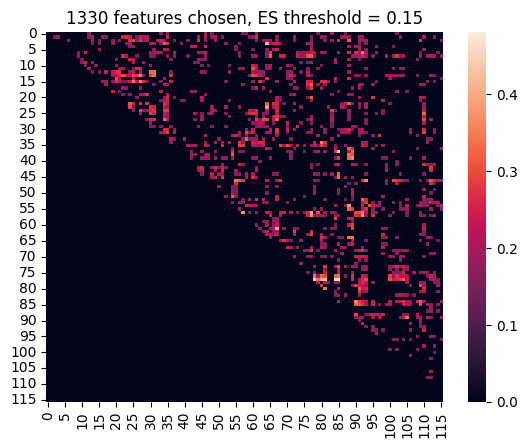

In [47]:
# Set up possible values of parameters to optimize over
p_grid = {"SVC": {'C': [0.1, 1, 100], 'gamma': [1e-06, 1e-05, 0.0001]},
          "IidakaTransformer": {
            "a_label": ["ASD"],
            "b_label": ["TD"],
            "effect_size_threshold": [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35]
            }
          }

pipe = [IidakaTransformer, StandardScaler, SVC]


inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

results, summary = classification.nested_grid_search_cv(X=graphs, y=labels, pipeline_steps=pipe, step_param_grids=p_grid, outer_cv=outer_cv, inner_cv=inner_cv, plot_prefix=f"{DATA_DESCRIPTOR}-NESTED-{DATASET_NAME}")


with open(f'./outputs/{DATA_DESCRIPTOR}-NestedGridSearchCV-Iidaka-{DATASET_NAME}.txt', 'a') as fp:
    fp.write("\n============================================================\n")
    fp.write("summary:\n" + str(summary) + "\n")
    for result in results:
        fp.write(str(result) + "\n")
    fp.write("parameter grid:\n" + str(p_grid) + "\n")
    fp.write("\n============================================================\n")